# Weakly Supervised Learning: Stack Overflow Tag Labeler

This is the first project for the book Weakly Supervised Learning, about using natural language processing (NLP) and weakly supervised learning (WSL) to build better models with less data. Using the non-code text of Stack Overflow posts (question and answers) to tag them using a multi-class, multi-label classifier based on 1D Convlutional Neural Networks.

In [13]:
import gc
import json
import math
import os
import re
import warnings

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyarrow
import tensorflow as tf
import tensorflow_hub as hub

# Disable all warnings
warnings.filterwarnings("ignore")

# Download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rjurney/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Always use a random seed for reproducible results

Using random seeds throughout makes our work reproducible - so we get the same tokenization consistently, for example.

In [2]:
np.random.seed(seed=1337)

## Test GPU Support for Tensorflow/Keras

The first thing to do is to verify that our JupyterLab Python environment on our Data Science Engine EC2 instance is properly configured to work with its onboard GPU. We use `tensorflow.test.is_gpu_available` and `tensorflow.compat.v2.config.experimental.list_physical_devices` to verify the GPUs are working with Tensorflow.

In [3]:
gpu_avail = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print(f'1 or more GPUs is available: {gpu_avail}')

avail_gpus = tf.compat.v2.config.experimental.list_physical_devices('GPU')
print(f'GPUs on tap: {avail_gpus}')

1 or more GPUs is available: True
GPUs on tap: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Widen the Max Width of Pandas Columns

We want to be able to see the text of the questions in our tables.

In [4]:
pd.set_option('display.max_colwidth', 400)

## Configure the Application

Setup the batch size, document size, token count for the tokenizer/embedding, the embedding dimensions and the test/train split ratio.

In [5]:
BATCH_SIZE  = 64
MAX_LEN     = 200
TOKEN_COUNT = 10000
EMBED_SIZE  = 50
TEST_SPLIT  = 0.3

## Load a Stratified Sample of Answered Stack Overflow Questions with Tags

We load a sample pulled from all answered questions from Stack Overflow. This data was converted from XML to parquet format via [code/stackoverflow/xml_to_parquet.py](stackoverflow/sample_json.spark.py) and then a more balanced stratified sample was computed for tags with over 50,000, 20,000, 10,000, 5,000 and 2,000 instances that reduced the maximum imbalance via oversampling using [code/stackoverflow/get_questions.spark.py](stackoverflow/get_questions.spark.py).

These scripts were run using a Spark cluster via Amazon Elastic MapReduce using 13 r5.12xlarge machines for about 24 hours at a cost of about \\$300 per full run, and about \\$1,500 overall to create and debug. Big data is expensive. The latter parts of the run could be computed on my own 6 core/64GB machine with NVM drives for data/Spark caching.

With this dataset the challenge isn't the number of records per say but rather the imbalance of the dataset if we wish to expand the number of tags the model can predict beyond low 3 digits. This leads us to some of the other techniques we'll cover involving weakly supervised learning.

In [6]:
# Tag limit defines which dataset to load - those with tags having at least 50K, 20K, 10K, 5K or 2K instances
TAG_LIMIT = 2000

# Pre-computed sorted list of tag/index pairs
sorted_all_tags = json.load(open(f'data/stackoverflow/08-05-2019/sorted_all_tags.{TAG_LIMIT}.json'))
max_index = sorted_all_tags[-1][0] + 1

# Load the parquet file using pyarrow for this tag limit, using the sorted tag index to specify the columns
posts_df = pd.read_parquet(
    f'data/stackoverflow/08-05-2019/Questions.Stratified.Final.{TAG_LIMIT}.parquet',
    columns=['_Body'] + ['label_{}'.format(i) for i in range(0, max_index)],
    engine='pyarrow'
)
posts_df.head(2)

,_Body,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_776,label_777,label_778,label_779,label_780,label_781,label_782,label_783,label_784,label_785
0,"[How, animate, Flutter, layout, keyboard, appearance, I, building, Flutter, app, mainly, iOS, One, views, text, field, iOS, keyboard, appears, tap, The, problem, layout, change, smoothly, like, native, iOS, apps, Instead, instantly, jumps, final, available, screen, height, even, keyboard, opening, animation, finishes, I, tried, wrapping, SafeArea, element, help, My, layout, code, How, I, make,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[Creating, Carousel, using, FutureBuilder, I, storing, images, Firestore, Document, would, like, load, using, FutureBuilder, Here, I, done, far, Using, code, I, display, image, without, errors, However, I, know, loop, snapshot, data, display, list, images, Below, firestore, structure, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__, __...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(
    '{:,} Stackoverflow questions with a tag having at least 2,000 occurrences'.format(
        len(posts_df.index)
    )
)

1,554,788 Stackoverflow questions with a tag having at least 2,000 occurrences


## Sanity Check the Labels

There shouldn't be any rows that are all zeros - it throws off the metrics computed during training. There shouldn't be more than six tags for one question, there is a hard limit in the Stack Overflow UI.

In [19]:
test_matrix = posts_df[[f'label_{i}' for i in range(0, max_index)]].as_matrix()

tests = np.count_nonzero(test_matrix.sum(axis=1)), \
        test_matrix.sum(axis=1).shape[0], \
        test_matrix.sum(axis=1).min(), \
        test_matrix.sum(axis=1).max()

print(f'Non-zero rows: {tests[0]:,}, Total rows: {tests[1]:,}, Non-zero ratio: {tests[0]/tests[1]:,}, Least tags: {tests[2]:,}, Most tags: {tests[3]:,}')

Non-zero rows: 1,554,788, Total rows: 1,554,788, Non-zero ratio: 1.0, Least tags: 1, Most tags: 6


## Load the Precomputed Indexes for Converting Between Tag Indexes and Tags

At the end, when we visualize the predictions of our model versus the test data, we will use these indexes to convert from numeric predictions corresponding to tag indexes in a matrix to actual text tags. 

In [8]:
tag_index = json.load(open(f'data/stackoverflow/08-05-2019/tag_index.{TAG_LIMIT}.json'))
index_tag = json.load(open(f'data/stackoverflow/08-05-2019/index_tag.{TAG_LIMIT}.json'))

# Sanity check the different files
assert( len(tag_index.keys()) == len(index_tag.keys()) == len(sorted_all_tags) )

## Make Record Count a Multiple of the Batch Size and Post Sequence Length

GloVe embeddings and multi-GPU support require that the number of records be a multiple of the batch size times the number of tokens in the padded posts.

We also join the previously tokenized text into a single string to use `tf.keras.preprocessing.text.Tokenizer`.

In [14]:
# Convert label columns to numpy array
labels = posts_df[list(posts_df.columns)[1:]].to_numpy()

# Training_count must be a multiple of the BATCH_SIZE times the MAX_LEN for the Elmo embedding layer
highest_factor = math.floor(len(posts_df.index) / (BATCH_SIZE * MAX_LEN))
training_count = highest_factor * BATCH_SIZE * MAX_LEN
print('Highest Factor: {:,} Training Count: {:,}'.format(highest_factor, training_count))

documents = []
for body in posts_df[0:training_count]['_Body'].values.tolist():
    words = body.tolist()
    documents.append(' '.join(words))

labels = labels[0:training_count]

# Conserve RAM
del posts_df
gc.collect()

# Lengths for x and y match
assert( len(documents) == training_count == labels.shape[0] )

Highest Factor: 121 Training Count: 1,548,800


### Trim/Pad the Questions to 200 Words

The data has already been truncated to 200 words per post but the tokenization using the top 10K words reduces this to below 200 in some documents. If any documents vary from 200 words, the data won't convert properly into a numpy matrix below.

Note that the string `__PAD__` has been used previously to pad the documents, so we use it here for words missing in the top `TOKEN_COUNT` words, in our `Tokenizer`.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(
    num_words=TOKEN_COUNT,
    oov_token='__PAD__'
)
tokenizer.fit_on_texts(documents)

sequences = tokenizer.texts_to_sequences(documents)

padded_sequences = pad_sequences(
    sequences,
    maxlen=MAX_LEN,
    dtype='int32',
    padding='post',
    truncating='post',
    value=1
)

# Conserve RAM
del documents
del sequences
gc.collect()

# Verify that all padded documents are now the same length
assert( min([len(x) for x in padded_sequences]) == MAX_LEN == max([len(x) for x in padded_sequences]) )

padded_sequences.shape

(1548800, 200)

## Load GloVe Embeddings

Stanford defines [GloVe Embeddings](https://nlp.stanford.edu/projects/glove/) as:

> GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

We'll try them out to see if they can beat our own embedding, specific to our data.

In [11]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('data/GloVe/glove.6B.50d.txt'))

In [12]:
# Create embeddings matrix
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

# Create embedding matrix using our vocabulary
word_index = tokenizer.word_index
print('word_index', word_index)
nb_words = min(TOKEN_COUNT, len(word_index))

# Initialize embedding matrix
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, 50))

# Loop through each word and get its embedding vector
missing_count = 0
too_short_count = 0
for word, i in word_index.items():
    if i >= TOKEN_COUNT: 
        too_short_count += 1
        continue # Skip words appearing less than the minimum allowed
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
    else:
        missing_count += 1

print(missing_count, too_short_count, embedding_matrix[0])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Split Data into Test/Train Datasets

We must split our data so that we test on 

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    labels,
    test_size=TEST_SPLIT,
    random_state=1337
)

# Conserve RAM
del padded_sequences
del labels
gc.collect()

assert(X_train.shape[0] == y_train.shape[0])
assert(X_train.shape[1] == MAX_LEN)
assert(X_test.shape[0] == y_test.shape[0]) 
assert(X_test.shape[1] == MAX_LEN)

## Use Class Weights to Balance Uneven Label Counts

Although there has already been filtering and up-sampling of the data to restrict it to a sample of questions with at least one tag that occurs more than 2,000 times, there are still as much as a 8000:1 ratio between common and uncommon labels. Without class weights, the most common label will be much more likely to be predicted than the least common.

In [34]:
train_weight_vec = list(np.max(np.sum(y_train, axis=0))/np.sum(y_train, axis=0))
train_class_weights = {i: train_weight_vec[i] for i in range(y_train.shape[1])}

test_weight_vec = list(np.max(np.sum(y_test, axis=0))/np.sum(y_test, axis=0))
test_class_weights = {i: test_weight_vec[i] for i in range(y_test.shape[1])}

sorted(list(train_class_weights.items()), key=lambda x: x[1]), sorted(list(test_class_weights.items()), key=lambda x: x[1])

([(356, 1.0),
  (90, 1.0873881204231082),
  (361, 1.3316481188181122),
  (546, 1.3770594934649385),
  (17, 1.6345822067722415),
  (516, 1.7743211325870334),
  (92, 1.811382670604517),
  (343, 2.4092987949520825),
  (371, 3.157138238877975),
  (1, 3.686995411511878),
  (309, 3.9223306969846763),
  (89, 4.019693515704154),
  (150, 4.610451392671678),
  (628, 4.77231891140097),
  (483, 5.107946087306377),
  (350, 5.164673338214954),
  (53, 5.270591165725673),
  (581, 5.448139724498992),
  (459, 5.677906976744186),
  (471, 6.0246761258482415),
  (552, 6.332069825436409),
  (405, 6.601050278167732),
  (629, 7.383425414364641),
  (580, 7.415771028037383),
  (183, 7.422708138447147),
  (653, 7.643467790487658),
  (51, 7.91558077186857),
  (34, 8.287075718015666),
  (753, 8.489334670678703),
  (56, 8.502980376398098),
  (766, 8.639537257570602),
  (378, 8.76781767955801),
  (622, 9.085301273794189),
  (457, 9.644333029474323),
  (590, 9.853162592161429),
  (647, 10.145277289435832),
  (773, 10

## Create a Performance Log for the Model

We will log the original performance as a reference point as well as the performance of the latest model to the current run.

In [30]:
try:
    simple_log
except NameError:
    simple_log = []

with open('data/simple_log.jsonl') as f:
    for line in f:
        simple_log.append(json.loads(line))

SEQUENCE = simple_log[-1]['sequence'] if len(simple_log) > 0 else 0

## Try a Simple CNN Model to Classify Questions to their Corresponding Tags

We start with a simple model with one `Conv1D`/`GlobalMaxPool1D`.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy, kld
from tensorflow.keras.optimizers import Adam

FILTER_COUNT        = 128
FILTER_SIZE         = 3
EPOCHS              = 5
ACTIVATION          = 'selu'
CONV_PADDING        = 'same'
STRIDES             = 1
EMBED_SIZE          = 50
EMBED_DROPOUT_RATIO = 0.1
CONV_DROPOUT_RATIO  = 0.1

EXPERIMENT_NAME = 'simple_cnn'

if EXPERIMENT_NAME == simple_log[-1]['name']:
    print('RENAME YOUR EXPERIMENT')
    raise Exception('RENAME YOUR EXPERIMENT')

SEQUENCE += 1

# Weights and Biases Monitoring
import wandb
from wandb.keras import WandbCallback
wandb.init(project="weakly-supervised-learning", name=EXPERIMENT_NAME)
config = wandb.config

config.update(
    {
        'name': EXPERIMENT_NAME,
        'embedding': 'own',
        'architecture': 'Kim CNN',
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'filter_count': FILTER_COUNT,
        'filter_size': FILTER_SIZE,
        'activation': ACTIVATION,
        'conv_padding': CONV_PADDING,
        'sequence': SEQUENCE
    }
)

model = Sequential()

model.add(
    Embedding(
        TOKEN_COUNT,
        EMBED_SIZE, 
        input_length=X_train.shape[1],
        embeddings_initializer=RandomUniform(),
    )
)
# model.add(
#     Embedding(
#         TOKEN_COUNT,
#         EMBED_SIZE,
#         weights=[embedding_matrix],
#         input_length=MAX_LEN,
#         trainable=True
#     )
# )
model.add(Dropout(0.1))
model.add(
    Conv1D(
        FILTER_COUNT, 
        FILTER_SIZE, 
        padding=CONV_PADDING, 
        activation=ACTIVATION, 
        strides=1
    )
)
model.add(GlobalMaxPool1D())
model.add(
    Dense(
        y_train.shape[1],
        activation='sigmoid',
    )
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'categorical_accuracy',
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.FalseNegatives(),
    ]
)
model.summary()

callbacks = [
    ReduceLROnPlateau(
        monitor='val_categorical_accuracy',
        factor=0.1,
        patience=1,
    ), 
    EarlyStopping(
        patience=2
    ), 
    ModelCheckpoint(
        filepath='models/cnn_tagger.weights.hdf5',
        monitor='val_categorical_accuracy',
        save_best_only=True
    ),
    WandbCallback()
]

history = model.fit(X_train, y_train,
                    class_weight=train_class_weights,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=TEST_SPLIT,
                    callbacks=callbacks)

[{'loss': 0.025429034848639277,
  'categorical_accuracy': 0.4202008843421936,
  'precision': 0.7850497364997864,
  'recall': 0.561117947101593,
  'binary_accuracy': 0.9912359118461609,
  'hinge': 0.9985249042510986,
  'auc': 0.977318286895752,
  'accuracy': 0.028561104089021683,
  'mean_absolute_error': 0.013315621763467789,
  'mean_absolute_percentage_error': 6739443.0,
  'true_positives': 178463.0,
  'false_positives': 48864.0,
  'true_negatives': 21137114.0,
  'false_negatives': 139586.0,
  'name': 'kim_cnn_complex',
  'sequence': 35,
  'f1': 0.32722929088516656},
 {'loss': 0.025429034848639277,
  'categorical_accuracy': 0.4202008843421936,
  'precision': 0.7850497364997864,
  'recall': 0.561117947101593,
  'binary_accuracy': 0.9912359118461609,
  'hinge': 0.9985249042510986,
  'auc': 0.977318286895752,
  'accuracy': 0.028561104089021683,
  'mean_absolute_error': 0.013315621763467789,
  'mean_absolute_percentage_error': 6739443.0,
  'true_positives': 178463.0,
  'false_positives': 4

## Train a Kim-CNN Model to Classify Questions to their Corresponding Tags

We will train a model to classify questions into categories corresponding to tags based on [Kim-CNN](https://arxiv.org/abs/1408.5882).

In [2]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import (
    Dense, Activation, Embedding, Flatten, MaxPool1D, GlobalMaxPool1D, Dropout, Conv1D, Input, concatenate
)
from tensorflow.keras.losses import binary_crossentropy, kld
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras_radam import RAdam

EXPERIMENT_NAME = 'kim_cnn_2000_embed_50_drop'

FILTER_COUNT        = 128
FILTER_SIZE         = [3, 4, 5]
EPOCHS              = 5
ACTIVATION          = 'selu'
CONV_PADDING        = 'same'
EMBED_SIZE          = 50
EMBED_DROPOUT_RATIO = 0.1
CONV_DROPOUT_RATIO  = 0.1

if EXPERIMENT_NAME == simple_log[-1]['name']:
    print('RENAME YOUR EXPERIMENT')
    raise Exception('RENAME YOUR EXPERIMENT')

SEQUENCE += 1

# Weights and Biases Monitoring
import wandb
from wandb.keras import WandbCallback
wandb.init(project="weakly-supervised-learning", name=EXPERIMENT_NAME)
config = wandb.config

config.update(
    {
        'name': EXPERIMENT_NAME,
        'embedding': 'own',
        'architecture': 'Kim CNN',
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'filter_count': FILTER_COUNT,
        'filter_size': FILTER_SIZE,
        'activation': ACTIVATION,
        'conv_padding': CONV_PADDING,
        'sequence': SEQUENCE
    }
)

padded_input = Input(
    shape=(X_train.shape[1],),
    dtype='int32'
)

emb = Embedding(
    TOKEN_COUNT, 
    EMBED_SIZE,
    embeddings_initializer=RandomUniform(),
    input_length=X_train.shape[1]
)(padded_input)
# emb = Embedding(
#     TOKEN_COUNT,
#     EMBED_SIZE,
#     weights=[embedding_matrix],
#     input_length=MAX_LEN,
#     trainable=True,
# )(padded_input)
drp = Dropout(0.1)(emb)

# Create convlutions of different sizes
convs = []
for filter_size in FILTER_SIZE:
    f_conv = Conv1D(
        filters=FILTER_COUNT,
        kernel_size=filter_size,
        padding=CONV_PADDING,
        activation=ACTIVATION
    )(drp)
    f_pool = MaxPool1D(filter_size)(f_conv)
    convs.append(f_pool)

l_merge = concatenate(convs, axis=1)
l_conv = Conv1D(
    128,
    5,
    activation=ACTIVATION
)(l_merge)
l_pool = GlobalMaxPool1D()(l_conv)
l_flat = Flatten()(l_pool)
l_drp  = Dropout(CONV_DROPOUT_RATIO)(l_flat)
l_dense = Dense(
    128,
    activation=ACTIVATION
)(l_drp)
out_dense = Dense(
    y_train.shape[1],
    activation='sigmoid'
)(l_dense)

model = Model(inputs=padded_input, outputs=out_dense)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Hinge(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.FalseNegatives(),
    ]
)
model.summary()

callbacks = [
    ReduceLROnPlateau(
        monitor='val_categorical_accuracy',
        factor=0.1,
        patience=1,
    ), 
    EarlyStopping(
        patience=3
    ), 
    ModelCheckpoint(
        filepath='models/cnn_tagger.weights.hdf5',
        monitor='val_categorical_accuracy',
        save_best_only=True
    ),
    WandbCallback()
]

history = model.fit(X_train, y_train,
                    class_weight=train_class_weights,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Using TensorFlow backend.


NameError: name 'simple_log' is not defined

In [39]:
model = tf.keras.models.load_model('models/cnn_tagger.weights.hdf5')
metrics = model.evaluate(X_test, y_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
log = {}
for name, val in zip(model.metrics_names, metrics):
    
    if name[-1].isdigit():
        repeat_name = '_'.join(name.split('_')[:-1])
    else:
        repeat_name = name
    py_val = val.item() if isinstance(val, np.float32) else val
    
    log[repeat_name] = py_val
    
log.update({'name': EXPERIMENT_NAME})
log.update({'sequence': SEQUENCE})

log.update({'f1': (log['precision'] * log['recall']) / (log['precision'] + log['recall'])})

simple_log.append(log)

with open('data/simple_log.jsonl', 'w') as f:
    [f.write(json.dumps(l) + '\n') for l in simple_log]

for key, val in log.items():
    if key not in ['name', 'sequence']:
        print(f'{key}: {val:.3f}')

loss: 0.018
categorical_accuracy: 0.314
precision: 0.391
recall: 0.718
binary_accuracy: 0.995
hinge: 1.009
auc: 0.984
accuracy: 0.002
mean_absolute_error: 0.012
mean_absolute_percentage_error: 11001994.000
true_positives: 313114.000
false_positives: 488274.000
true_negatives: 120811464.000
false_negatives: 122729.000
f1: 0.253


In [41]:
# Compare to original
if len(simple_log) > 1:
    d2 = simple_log[-1]
    d1 = simple_log[0]
else:
    d1 = simple_log[0]
    d2 = simple_log[0]
log_diff_1 = {key: d2.get(key, 0) - d1.get(key, 0) for key in d1.keys() if key not in ['name', 'sequence']}
log_diff_1['current'] = d2['name']
log_diff_1['previous'] = d1['name']

# Compare to last run
if len(simple_log) > 1:
    d1 = simple_log[-2]
    d2 = simple_log[-1]
else:
    d1 = simple_log[0]
    d2 = simple_log[0]
    
log_diff_2 = {key: d2.get(key, 0) - d1.get(key, 0) for key in d1.keys() if key not in ['name', 'sequence']}
log_diff_2['current'] = d2['name']
log_diff_2['previous'] = d1['name']

df = pd.DataFrame.from_dict([log_diff_1, log_diff_2])
cols = df.columns.tolist()
cols.remove('previous')
cols.remove('current')
show_cols = ['previous', 'current'] + cols
df[show_cols]

,previous,current,accuracy,auc,binary_accuracy,categorical_accuracy,f1,false_negatives,false_positives,hinge,loss,mean_absolute_error,mean_absolute_percentage_error,precision,recall,true_negatives,true_positives
0,kim_cnn_complex,kim_cnn_2000,-0.026696,0.006748,0.003744,-0.106261,-0.074153,-16857.0,439410.0,0.010007,-0.007781,-0.001203,4262551.0,-0.394335,0.157292,99674350.0,134651.0
1,kim_cnn_limit_10_epochs_save_best_2,kim_cnn_2000,0.001319,-0.000114,0.002843,-0.069544,-0.039768,12092.0,177525.0,0.000014,-0.007302,-0.004031,-2849897.0,-0.098685,-0.010741,67955032.0,15268.0


In [42]:
log_df = pd.DataFrame(simple_log)
log_df['f1'] = (log_df['precision'] * log_df['recall']) / (log_df['precision'] + log_df['recall'])

log_df[[
    'sequence',
    'name',
    'loss',
    'categorical_accuracy',
    'precision',
    'recall',
    'f1',
    'auc',
    'true_positives',
    'false_positives',
    'true_negatives',
    'false_negatives',
    'hinge',
    'mean_absolute_error',
]]

,sequence,name,loss,categorical_accuracy,precision,recall,f1,auc,true_positives,false_positives,true_negatives,false_negatives,hinge,mean_absolute_error
0,35,kim_cnn_complex,0.025429,0.420201,0.785050,0.561118,0.327229,0.977318,178463.0,48864.0,21137114.0,139586.0,0.998525,0.013316
1,35,kim_cnn_complex,0.025429,0.420201,0.785050,0.561118,0.327229,0.977318,178463.0,48864.0,21137114.0,139586.0,0.998525,0.013316
2,35,kim_cnn_complex,0.025429,0.420201,0.785050,0.561118,0.327229,0.977318,178463.0,48864.0,21137114.0,139586.0,0.998525,0.013316
3,36,basic_cnn,0.028156,0.421450,0.677476,0.659971,0.334304,0.982044,209903.0,99928.0,21086010.0,108146.0,1.001925,0.016715
4,37,basic_cnn_5000_limit,0.016947,0.380762,0.661913,0.594659,0.313243,0.978033,242908.0,124071.0,53043088.0,165575.0,1.002064,0.009689
5,38,basic_cnn_5000_limit_10_epochs,0.017176,0.381195,0.643383,0.611039,0.313397,0.979239,249599.0,138349.0,53028884.0,158884.0,1.002358,0.009983
6,40,kim_cnn_5000_limit_10_epochs,0.013641,0.397833,0.786248,0.548924,0.323247,0.977590,224226.0,60959.0,53106280.0,184257.0,0.999238,0.006862
7,41,kim_cnn_5000_limit_10_epochs_save_best,0.014030,0.399011,0.794837,0.522090,0.315110,0.975943,213265.0,55048.0,53112236.0,195218.0,0.999323,0.006946
8,42,simple_5000_limit_10_epochs_save_best,0.024671,0.380396,0.490458,0.749843,0.296514,0.985702,306298.0,318216.0,52849048.0,102185.0,1.008430,0.016055
9,44,kim_cnn_limit_10_epochs_save_best,0.023322,0.385321,0.510684,0.725247,0.299671,0.984288,296251.0,283855.0,52883420.0,112232.0,1.007342,0.014967


In [45]:
X_test_text = tokenizer.sequences_to_texts(X_test)

In [47]:
y_test_tags = []
for row in y_test.tolist():
    tags = [index_tag[str(i)] for i, col in enumerate(row) if col == 1]
    y_test_tags.append(tags)

## Adjust the threshold for classification

This lets us see how well the model generalizes to labeling more classes.

In [77]:
CLASSIFY_THRESHOLD = 0.5

y_pred = model.predict(X_test)
y_pred = (y_pred > CLASSIFY_THRESHOLD) * 1

y_pred_tags = []
for row in y_pred.tolist():
    tags = [index_tag[str(i)] for i, col in enumerate(row) if col > CLASSIFY_THRESHOLD]
    y_pred_tags.append(tags)

In [78]:
np.around(y_pred, 0).sum(axis=0) - y_test.sum(axis=0)

array([  190, -3649,   310,   129,   228,    84,   155,   127,    92,
         233,   503,  -351,    81,  -153,    55,    99,   -24, -2473,
         793,   827,   173,   422,   738,  1243,   261,   948,  1331,
         629,   474,   153,   531,   585,    59,   624,  -124,   146,
         218,    62,    36,    80,     8,    20,     2,   100,  -446,
         444,  -251,    84,   460,   172,   567,  -286,   178, -1255,
         115,   108,  -647,   396,   162,    88,   134,    64,   333,
         240,  -166,   117,   162,  -398,    88,   800,  -106,   233,
           8,    51,    23,   281,  -178,   154,   296,    46,   -94,
         293,   101,    28,   263,   517,     0,  -320,   384,   266,
       -6893,  -364, -2516,    78,   252,   198,  -107,    -1,   146,
          10,   172,   149,     9,   154,   216,   321,   171,   -12,
         198,   187,   -65,     8,    63,    48,   346,   120,   717,
         -25,  -149,     3,   -26,   191,   219,    41,    82,   -60,
         140,   -85,

In [84]:
`

[('using variables gulp destination file name i new gulp i wondering i want achieve practical possible my projects structure now i want gulp stores compiled css files according css folder public assets uses name folder found scss file is possible do i need pipe plugin thanks ps realize i could achieve renaming scss i like avoid pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad',
  ['gulp', 'sass'],
  ['css', 'gulp', 'javascript', 'sass']),
 ('woocommerce get custom sele

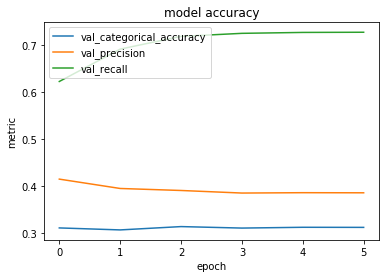

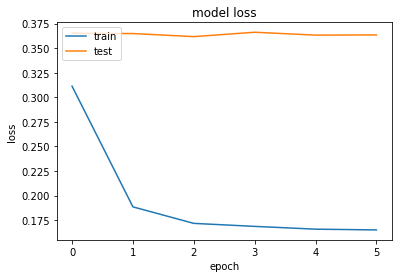

In [63]:
%matplotlib inline

viz_keys = ['val_categorical_accuracy', 'val_precision', 'val_recall']
# summarize history for accuracy
for key in viz_keys:
    plt.plot(history.history[key])
plt.title('model accuracy')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(viz_keys, loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import sys

## Model imports
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import ( Input, Embedding, GlobalMaxPooling1D, Conv1D, Dense, Activation, 
                                      Dropout, Lambda, BatchNormalization, concatenate )
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.text import Tokenizer

# Fit imports
from tensorflow.keras.losses import hinge, mae, binary_crossentropy, kld, Huber, squared_hinge

# Hyperparameter/method search space
import itertools

# For 4 GPUs
DIST_BATCH_SIZE = 64
EPOCHS = 10


print('Starting experiment loop...')

EXPERIMENT_NAME = 'kld dense dims x filter_lengths x adam/sgd'
learning_rates = [None]
losses = [binary_crossentropy]#, kld, hinge, mae]
activations = ['selu'] # 'selu'
optimizers = ['adam']
dropout_ratios = [0.2]
filter_lengths = [300]
class_weight_set = [train_class_weights]
sample_weight_set = [None], #, train_sample_weights]
test_sample_weight_set = [None] #, test_sample_weights]
dense_dims = [32]

args = list(itertools.product(
    learning_rates,
    losses,
    activations,
    optimizers,
    dropout_ratios,
    filter_lengths,
    class_weight_set,
    sample_weight_set,
    test_sample_weight_set,
    dense_dims
))
print()
print(f'{len(args):,} total iterations...')
sys.stdout.flush()

In [ ]:
# Weights and Biases Monitoring
import wandb
from wandb.keras import WandbCallback
wandb.init(project="weakly-supervised-learning", name=EXPERIMENT_NAME)
config = wandb.config

# tqdm_notebook
for learning_rate, loss_function, activation, optimizer, dropout_ratio, filter_length, class_weights, \
    sample_weights, test_sample_weights, dense_dim in args:
    
    cw_label  = 'class_weights' if isinstance(class_weights, dict) else 'no_class_weights'
    sw_label  = 'sample_weights' if isinstance(sample_weights, np.ndarray) else 'no_sample_weights'
    tsw_label = 'test_sample_weights' if isinstance(test_sample_weights, list) else 'no_test_sample_weights'
    
    model_name = str(loss_function.__name__) + ' ' + str(learning_rate) + ' ' + str(optimizer) + ' ' + \
                 str(activation) + ' ' + str(EPOCHS) + ' ' + cw_label + ' ' + sw_label + ' ' + tsw_label + ' ' + \
                 str(dense_dim)
    
    # Log wandb config
    config.update(
        {
            'class_weights': cw_label,
            'sample_weights': sw_label,
            'test_sample_weights': tsw_label,
        },
        allow_val_change=True
    )
    
    print(model_name)
    sys.stdout.flush()
    
    #
    # Build ze model...
    #
    def build_model(
        token_count=None,
        max_words=None,
        embedding_dim=None,
        label_count=None,
        dropout_ratio=None,
        filter_length=None,
        loss_function=None,
        learning_rate=None,
        optimizer=None,
        activation=None,
        dense_dim=None,
    ):
        """Build the model using this experiment's parameters"""
        
        # Store config in wandb
        config.update(
            {
                'token_count': token_count,
                'max_words': max_words,
                'embedding_dim': embedding_dim,
                'label_count': label_count,
                'dropout_ratio': dropout_ratio,
                'filter_length': filter_length,
                'loss_function': loss_function.__name__,
                'learning_rate': learning_rate,
                'optimizer': optimizer,
                'activation': activation,
                'dense_dim': dense_dim,
            },
            allow_val_change=True
        )
        
        mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])#, "/gpu:1", "/gpu:2", "/gpu:3"])
        with mirrored_strategy.scope():
            
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
        
            hashed_input = Input(shape=(X_train.shape[1],), dtype='int64')

            # emb = Embedding(token_count, embedding_dim, weights=[embedding_matrix])(hashed_input)
            emb = Embedding(max_words, 20, input_length=maxlen)(hashed_input)

#             # Specify each convolution layer and their kernel siz i.e. n-grams 
#             conv1_1 = Conv1D(filters=filter_length, kernel_size=3)(emb)
#             btch1_1 = BatchNormalization()(conv1_1)
#             drp1_1  = Dropout(dropout_ratio)(btch1_1)
#             actv1_1 = Activation(activation)(drp1_1)
#             glmp1_1 = GlobalMaxPooling1D()(actv1_1)

#             conv1_2 = Conv1D(filters=filter_length, kernel_size=4)(emb)
#             btch1_2 = BatchNormalization()(conv1_2)
#             drp1_2  = Dropout(dropout_ratio)(btch1_2)
#             actv1_2 = Activation(activation)(drp1_2)
#             glmp1_2 = GlobalMaxPooling1D()(actv1_2)

#             conv1_3 = Conv1D(filters=filter_length, kernel_size=5)(emb)
#             btch1_3 = BatchNormalization()(conv1_3)
#             drp1_3  = Dropout(dropout_ratio)(btch1_3)
#             actv1_3 = Activation(activation)(drp1_3)
#             glmp1_3 = GlobalMaxPooling1D()(actv1_3)

#             conv1_4 = Conv1D(filters=filter_length, kernel_size=6)(emb)
#             btch1_4 = BatchNormalization()(conv1_4)
#             drp1_4  = Dropout(dropout_ratio)(btch1_4)
#             actv1_4 = Activation(activation)(drp1_4)
#             glmp1_4 = GlobalMaxPooling1D()(actv1_4)

#             # Gather all convolution layers
#             cnct = concatenate([glmp1_1, glmp1_2, glmp1_3, glmp1_4], axis=1)
#             drp1 = Dropout(dropout_ratio)(cnct)

#             dns1  = Dense(dense_dim, activation=activation)(drp1)
#             btch1 = BatchNormalization()(dns1)
#             drp2  = Dropout(dropout_ratio)(btch1)
            
            drp1 = Dropout(0.1)(emb)
            conv1 = Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1)(drp1)
            gmp1 = GlobalMaxPool1D()(conv1)

            out = Dense(y_train.shape[1], activation='sigmoid')(gmp1)

            text_model = Model(
                inputs=hashed_input, 
                outputs=out
            )

            if activation == 'adam':
                activation = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
            if activation == 'sgd':
                activation = SGD(lr=learning_rate)

            text_model.compile(
                optimizer=optimizer,
                loss=loss_function,
                metrics=[
                    'categorical_accuracy',
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.BinaryAccuracy(),
                    tf.keras.metrics.Hinge(),
                    tf.keras.metrics.AUC(),
                    tf.keras.metrics.Accuracy(),
                    tf.keras.metrics.MeanAbsoluteError(),
                    tf.keras.metrics.MeanAbsolutePercentageError(),
                    tf.keras.metrics.TruePositives(),
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.TrueNegatives(),
                    tf.keras.metrics.FalseNegatives()
                ]
            )
            #text_model.summary()

            return text_model

    #
    # Train ze model...
    #
    def train_model(
        model=None,
        X_train=None,
        X_test=None,
        learning_rate=None,
        loss_function=None,
        optimizer=None,
        activation=None,
        epochs=None,
        class_weights=None,
        sample_weights=None,
        test_sample_weights=None,
    ):
        """Train the model using the current parameters and evaluate performance"""
        
        # Log wandb config
        config.update(
            { 'epochs': epochs },
            allow_val_change=True,
        )
        
        callbacks = [
            ReduceLROnPlateau(
                patience=1,
                verbose=1,
                min_delta=0.001,
                min_lr=0.0005,
            ), 
            EarlyStopping(
                patience=2,
                min_delta=0.001,
                verbose=1,
                restore_best_weights=True
            ), 
            WandbCallback()
            #ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
        ]

        history = text_model.fit(
            X_train, 
            y_train,
            class_weight=class_weights,
            sample_weight=sample_weights,
            epochs=epochs,
            batch_size=DIST_BATCH_SIZE,
            validation_data=(X_test, y_test),
            callbacks=callbacks
        )
    
        # Evaluate to our log and return a description key and a list of metrics
        accr = text_model.evaluate(X_test, y_test, sample_weight=test_sample_weights)
        f1_score = 2.0 * (accr[1] * accr[2]) / \
                         (accr[1] + accr[2])
        return_val = [i for i in zip([j.item() for j in accr + [f1_score]], text_model.metrics_names + ['val_f1_score'])]

        return return_val

    #
    # main()
    #
    text_model = build_model(
        token_count=TOKEN_COUNT,
        max_words=100,
        embedding_dim=50,
        label_count=y_train.shape[1],
        filter_length=128,
        loss_function=loss_function,
        learning_rate=learning_rate,
        optimizer=optimizer,
        activation=activation,
        dropout_ratio=dropout_ratio,
        dense_dim=dense_dim,
    )
    try:
        accuracies = train_model(
            model=text_model,
            X_train=X_train,
            X_test=X_test,
            learning_rate=learning_rate,
            loss_function=loss_function,
            optimizer=optimizer,
            activation=activation,
            epochs=EPOCHS,
            class_weights=class_weights,
            sample_weights=sample_weights,
            test_sample_weights=test_sample_weights,
        )

        log_record = (model_name, accuracies)
        performance_log.append(log_record)

        with open('data/performance_log.jsonl', 'w') as f:
            for record in performance_log:
                f.write(json.dumps(record) + '\n')

        print(log_record)
        sys.stdout.flush()
    except KeyboardInterrupt as e:
        print('Aboring training run!')
        sys.stdout.flush()

print('Completed experiment loop!')

In [ ]:
%%wandb

In [ ]:
# from keras.callbacks import EarlyStopping

# EPOCHS = 4

# history = text_model.fit(
#     X_train,
#     y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     callbacks=[
#         EarlyStopping(monitor='loss', patience=1, min_delta=0.0001),
#         EarlyStopping(monitor='val_loss', patience=1, min_delta=0.0001),
#     ],
#     class_weight=class_weights,
#     # sample_weight=train_sample_weights,
#     validation_data=(X_test, y_test)
# )

In [ ]:
accr = text_model.evaluate(X_test, y_test) #, sample_weight=test_sample_weights)
[i for i in zip(accr, text_model.metrics_names)]

In [ ]:
%matplotlib inline

print(history.history)
# summarize history for accuracy
plt.plot(history.history['val_loss'])
#plt.plot(history.history['f1_m'])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['recall'])
plt.plot(history.history['precision'])
plt.title('model accuracy')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['val_loss', 'f1', 'categorical accuracy', 'MAE', 'precision'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import math, statistics

from sklearn.metrics import hamming_loss, jaccard_score
import keras.backend as K
import tensorflow as tf

trim_size = math.floor(X_test.shape[0] / 64) * 64
print(f'trim size: {trim_size:,}')

X_test_trim = X_test[:trim_size]
y_test_trim = y_test[:trim_size]

y_pred = model.predict(X_test_trim)

best_cutoff = 0
max_score = 0
for cutoff in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8]:
    y_pred_bin = np.greater(y_pred, cutoff)
    print('Cutoff: {:,}'.format(cutoff))
    print('Hamming loss: {:,}'.format(
        hamming_loss(y_test_trim, y_pred_bin)
    ))
    scores = []
    for j_type in ['micro', 'macro', 'weighted']:
        j_score = jaccard_score(y_test_trim, y_pred_bin, average=j_type)
        print('Jaccard {} score: {:,}'.format(
            j_type,
            j_score
        ))
        scores.append(j_score)
    print('')
    mean_score = statistics.mean(scores)
    if mean_score > max_score:
        best_cutoff = cutoff
        max_score = mean_score

print('Best cutoff was: {:,} with mean jaccard score of {:,}'.format(best_cutoff, max_score))

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

y_pred = text_model.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.where(y_pred > best_cutoff, 1, 0)

print(classification_report(y_test, y_pred_bool))

print(multilabel_confusion_matrix(y_test, y_pred_bool))

## View the Results

Now lets map from the one-hot-encoded tags back to the text tags and view them alongside the text of the original posts to sanity check the model and see if it really works.

In [ ]:
predicted_tags = []
for test, pred in zip(y_test, y_pred_bool):
    tags = []
    for i, val in enumerate(test):
        if pred[i] == 1.0:
            tags.append(sorted_all_tags[i])
    predicted_tags.append(tags)

for text, tags in zip(X_test, predicted_tags):
    print(' '.join(text), tags)